In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import platform
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pj_home = '/gdrive/My Drive/colab/EMNST_DACON'

os_env = platform.system()

if os_env == "Linux":
    # pj_home = "/".join(os.path.abspath(os.path.dirname(os.path.abspath('__file__'))).split("/")[:-1])
    data_home = pj_home + "/input/data/"
    
elif os_env == "Windows":
    # pj_home = "\\".join(os.path.abspath(os.path.dirname(os.path.abspath('__file__'))).split("\\")[:-1])
    data_home = pj_home + "\\input\\data\\"

In [4]:
train = data_home + "train.csv"
test = data_home + "test.csv"

In [5]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [6]:
df_train.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [7]:
df_test.head()

,id,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4


Text(0.5, 0.92, "Label's count distribution in train dataset")

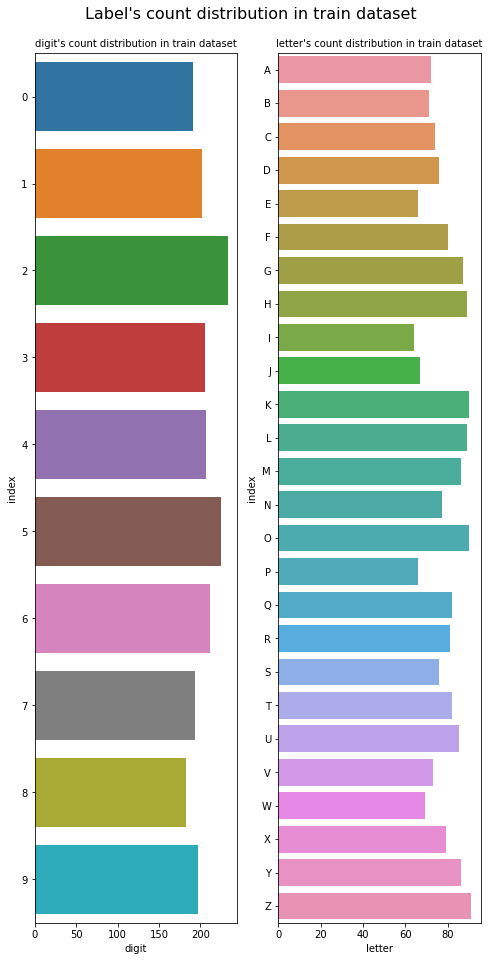

In [8]:
fig, axes = plt.subplots(figsize=[8,16],nrows=1,ncols=2)

target_cols = ["digit","letter"]

for idx, ax in enumerate(axes):

    column = target_cols[idx]
    dummy = df_train[column].value_counts().sort_index().reset_index()
    sns.barplot(data=dummy,x=column,y="index",orient='h',ax=ax,)

    ax.set_title(f"{column}'s count distribution in train dataset",fontsize=10)

plt.suptitle("Label's count distribution in train dataset",y=0.92,fontsize=16)

In [9]:
unq_letters = df_train.letter.value_counts().sort_index().index
idx_letter_dict = { idx:letter for idx, letter in enumerate(unq_letters) }
letter_idx_dict = { letter:idx for idx, letter in idx_letter_dict.items() }

In [10]:
# df_train.loc[:,"letter"] = df_train.letter.apply(lambda x:letter_idx_dict[x])

In [125]:
# fig, axes = plt.subplots(figsize=[8,16],nrows=1,ncols=2)

# target_cols = ["digit","letter"]

# for idx, ax in enumerate(axes):

#     column = target_cols[idx]
#     dummy = df_train[column].value_counts().sort_index().reset_index()
#     sns.barplot(data=dummy,x=column,y="index",orient='h',ax=ax,)

#     ax.set_title(f"{column}'s count distribution in train dataset",fontsize=10)

# plt.suptitle("Label's count distribution in train dataset",y=0.92,fontsize=16)

454


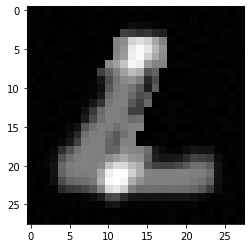

In [11]:
rand_num = np.random.randint(2048)
print(rand_num)
plt.imshow(df_train.loc[:,df_train.columns[3:]].iloc[rand_num].values.reshape(28,28),cmap="gray")

In [13]:
## FOLD별로 데이터셋을 분리하고, id이랑 character 붙이기.
import pickle
from tqdm import tqdm_notebook

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=101)
for fold, (trn_idx, valid_idx) in enumerate(kfold.split(X=df_train,y=df_train.digit)):
  df_train.loc[valid_idx,"fold"] = fold

df_train_imgs = df_train.loc[:,df_train.columns[3:-1]].values

def make_folder(directory_path):
  if not os.path.isdir(directory_path):
    os.mkdir(directory_path)

path_train = os.path.join(pj_home,'input/data/train')
make_folder(path_train)

for fold in range(5):
  fold_path = os.path.join(path_train,f'{fold}')
  make_folder(fold_path)

# path_test = os.path.join(pj_home,'input/data/test')
# make_folder(path_test)

## id_digit_letter 순으로 pkl명 생성
for idx,id in tqdm_notebook(enumerate(df_train.id.values)):
  img_id = id
  fold = df_train.loc[df_train.id==img_id,"fold"].values[0]
  digit = df_train.loc[df_train.id==img_id,"digit"].values[0]
  letter = df_train.loc[df_train.id==img_id,"letter"].values[0]
  img = df_train_imgs[idx,:]
  # http://taewan.kim/tip/python_pickle/ pickle 형태 저장
  with open(os.path.join(path_train,'%d/%d_%d_%c.pkl'%(fold,img_id,digit,letter)),'wb') as f:
    pickle.dump(img,f)
  # pickle data load
  # with open(os.path.join(path_train,'1/1_L.pkl'), 'rb') as f:
  #   img = pickle.load(f)

In [14]:
!pip install albumentations
!pip install opencv-python

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensor

train_transforms = A.Compose([
        A.Rotate(20),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    #pytorch가 학습에 사용할 수 있는 형태로 Image를 출력(HWC -> CHW)
    ToTensor()
    ])

valid_transforms = A.Compose([
    #pytorch가 학습에 사용할 수 있는 형태로 Image를 출력(HWC -> CHW)
    ToTensor()
    ])

In [349]:
from torchvision import transforms


train_transforms2= transforms.Compose([
  transforms.ToPILImage(),
  #agu.ImageNetPolicy(),
  
  # transforms.Resize([img_size,img_size]),
  #transforms.RandomResizedCrop(int(img_size*0.8)),
  transforms.RandomRotation(30),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(20),
  transforms.Grayscale(num_output_channels=1),
  #transforms.Resize([img_size,img_size]),
  transforms.ToTensor(),
  transforms.Normalize([0.5], [0.5])
])
valid_transforms2 = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Grayscale(num_output_channels=1),
    # transforms.Resize([img_size,img_size]),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
  ])

In [297]:
path_train

'/gdrive/My Drive/colab/EMNST_DACON/input/data/train'

In [298]:
np.random.seed(101)
valid_fold = np.random.randint(5)
train_folds = [idx for idx in range(5) if idx != valid_fold]

In [299]:
import re
pattern = '[0-9]+_[0-9]_[A-Z]'

trn_dict = dict()
val_dict = dict()
idx = 0
for trn_fold in train_folds:
  fold_path = os.path.join(path_train,str(trn_fold))
  for dir_name, _, file_names in os.walk(fold_path):
    for file_name in file_names:
      img_str= re.search(pattern,file_name).group()
      img_id, img_digit, img_letter = img_str.split("_")
      img_path = os.path.join(fold_path,file_name)
      # pickle data load
      with open(img_path, 'rb') as f:
        img = pickle.load(f)
        trn_dict[idx] = {"img_id":img_id, "digit":img_digit, "letter":img_letter, "img":img}
        idx +=1  

idx = 0
fold_path = os.path.join(path_train,str(valid_fold))
for dir_name, _, file_names in os.walk(fold_path):
  for file_name in file_names:
    img_str= re.search(pattern,file_name).group()
    img_id, img_digit, img_letter = img_str.split("_")
    img_path = os.path.join(fold_path,file_name)
    # pickle data load
    with open(img_path, 'rb') as f:
      img = pickle.load(f)
      val_dict[idx] = {"img_id":img_id, "digit":img_digit,"letter":img_letter, "img":img}  
      idx +=1

In [332]:
from  torch.utils.data import Dataset

class Emnst_Datset(Dataset):
  def __init__(self,img_dict,img_height,img_width,transform):
    self.img_dict = img_dict
    self.img_height = img_height
    self.img_width = img_width
    self.transform = transform

  def __len__(self):
    return len(self.img_dict)

  def __getitem__(self,index):
    img_dict = self.img_dict[index]
    img_id = img_dict["img_id"]
    img = img_dict["img"].reshape(self.img_height,self.img_width)
    digit = img_dict["digit"]
    letter = img_dict["letter"]
    img = img.astype("uint8")
    img = img[:,:,np.newaxis]
    img = np.repeat(img,3,2)

    if self.transform is not None:
      img = self.transform(image=img)["image"]

    digit = np.uint8(digit)

    return img, torch.tensor(digit,dtype=torch.long)

In [347]:
from  torch.utils.data import Dataset

class Emnst_Datset2(Dataset):
  def __init__(self,img_dict,img_height,img_width,transform):
    self.img_dict = img_dict
    self.img_height = img_height
    self.img_width = img_width
    self.transform = transform

  def __len__(self):
    return len(self.img_dict)

  def __getitem__(self,index):
    img_dict = self.img_dict[index]
    img_id = img_dict["img_id"]
    img = img_dict["img"].reshape(self.img_height,self.img_width)
    digit = img_dict["digit"]
    letter = img_dict["letter"]
    img = img.astype("uint8")

    if self.transform is not None:
      img = self.transform(img)

    digit = np.uint8(digit)

    return img, torch.tensor(digit,dtype=torch.long)

In [333]:
len(trn_dict)

1639

In [334]:
trn_dataset = Emnst_Datset(img_dict=trn_dict,img_height=28,img_width=28,transform=train_transforms)
val_dataset = Emnst_Datset(img_dict=val_dict,img_height=28,img_width=28,transform=valid_transforms)

In [350]:
trn_dataset2 = Emnst_Datset2(img_dict=trn_dict,img_height=28,img_width=28,transform=train_transforms2)
val_dataset2 = Emnst_Datset2(img_dict=val_dict,img_height=28,img_width=28,transform=valid_transforms2)

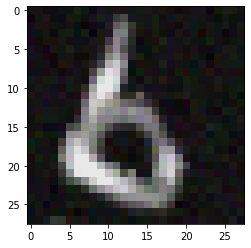

In [418]:
plt.imshow(trn_dataset[0][0].permute(1,2,0),cmap="gray")

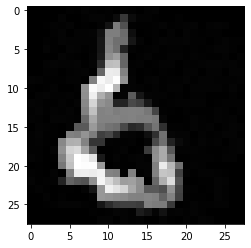

In [422]:
plt.imshow(trn_dataset2[0][0].reshape(28,28),cmap="gray")

In [362]:
from torch.utils.data import Dataset, DataLoader

trn_loader = DataLoader(trn_dataset, batch_size=16,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16,shuffle=False)

trn_loader2 = DataLoader(trn_dataset2, batch_size=16,shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=16,shuffle=False)

In [337]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [387]:
data = next(iter(trn_loader))

In [388]:
img, label = data

In [389]:
img.size()

torch.Size([16, 3, 28, 28])

In [390]:
label

tensor([2, 9, 5, 3, 3, 9, 8, 1, 0, 0, 2, 3, 1, 7, 3, 3])

In [391]:
# construct model on cuda if available

use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(1, 6, 5, 1) # 6@24*24
        # activation ReLU
        pool1 = nn.MaxPool2d(2) # 6@12*12
        conv2 = nn.Conv2d(6, 16, 5, 1) # 16@8*8
        # activation ReLU
        pool2 = nn.MaxPool2d(2) # 16@4*4
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(16*4*4, 120)
        # activation ReLU
        fc2 = nn.Linear(120, 84)
        # activation ReLU
        fc3 = nn.Linear(84, 10)

        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        # gpu로 할당
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) # @16*4*4
        # make linear
        dim = 1
        for d in out.size()[1:]: #16, 4, 4
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [392]:
cnn = CNNClassifier()

In [393]:

# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

In [402]:
# hyper-parameters
num_epochs = 100

In [409]:
import itertools
# # create figure for plotting
# row_num = 2
# col_num = 4
# fig, ax = plt.subplots(row_num, col_num, figsize=(6,6))
# for i, j in itertools.product(range(row_num), range(col_num)):
#     # ax[i,j].get_xaxis().set_visible(False)
#     # ax[i,j].get_yaxis().set_visible(False) 
    
# trn_loss_list = []
# val_loss_list = []

for epoch in range(num_epochs):
    trn_loss = 0.0
    for i, data in enumerate(trn_loader2):
        x, label = data
        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = cnn(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        
        # 학습과정 출력
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(val_loader2):
                    val_x, val_label = val
                    if use_cuda:
                        val_x = val_x.cuda()
                        val_label =val_label.cuda()
                    val_output = cnn(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss

            # # draw last val dataset
            # for k in range(row_num*col_num):
            #     ii = k//col_num
            #     jj = k%col_num
            #     ax[ii,jj].cla() # clear the current axis
            #     ax[ii,jj].imshow(val_x[k,:].data.cpu().numpy().reshape(28,28), cmap='Greys')
            
            # display.clear_output(wait=True)
            # display.display(plt.gcf()) # get a reference to a current figure
                
            print("label: {}".format(val_label[:row_num*col_num]))
            print("prediction: {}".format(val_output.argmax(dim=1)[:row_num*col_num]))
            del val_output
            del v_loss
            
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader2)
            ))            
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(val_loader2))
            trn_loss = 0.0

label: tensor([8, 2, 1, 1, 7, 8, 2, 2])
prediction: tensor([3, 2, 1, 1, 7, 8, 1, 6])
epoch: 1/100 | step: 100/103 | trn loss: 1.9244 | val loss: 2.0115
label: tensor([8, 2, 1, 1, 7, 8, 2, 2])
prediction: tensor([9, 2, 1, 1, 7, 8, 1, 1])
epoch: 2/100 | step: 100/103 | trn loss: 1.9088 | val loss: 2.0057
label: tensor([8, 2, 1, 1, 7, 8, 2, 2])
prediction: tensor([9, 2, 1, 1, 7, 8, 1, 6])
epoch: 3/100 | step: 100/103 | trn loss: 1.9104 | val loss: 2.0158
label: tensor([8, 2, 1, 1, 7, 8, 2, 2])
prediction: tensor([9, 3, 1, 1, 7, 8, 1, 1])
epoch: 4/100 | step: 100/103 | trn loss: 1.9188 | val loss: 2.0096
label: tensor([8, 2, 1, 1, 7, 8, 2, 2])
prediction: tensor([9, 2, 1, 1, 7, 8, 7, 6])
epoch: 5/100 | step: 100/103 | trn loss: 1.9009 | val loss: 1.9995
label: tensor([8, 2, 1, 1, 7, 8, 2, 2])
prediction: tensor([9, 2, 1, 1, 7, 5, 1, 1])
epoch: 6/100 | step: 100/103 | trn loss: 1.9260 | val loss: 2.0097
label: tensor([8, 2, 1, 1, 7, 8, 2, 2])
prediction: tensor([9, 2, 1, 1, 7, 8, 1, 6])
epo

Text(0, 0.5, 'loss')

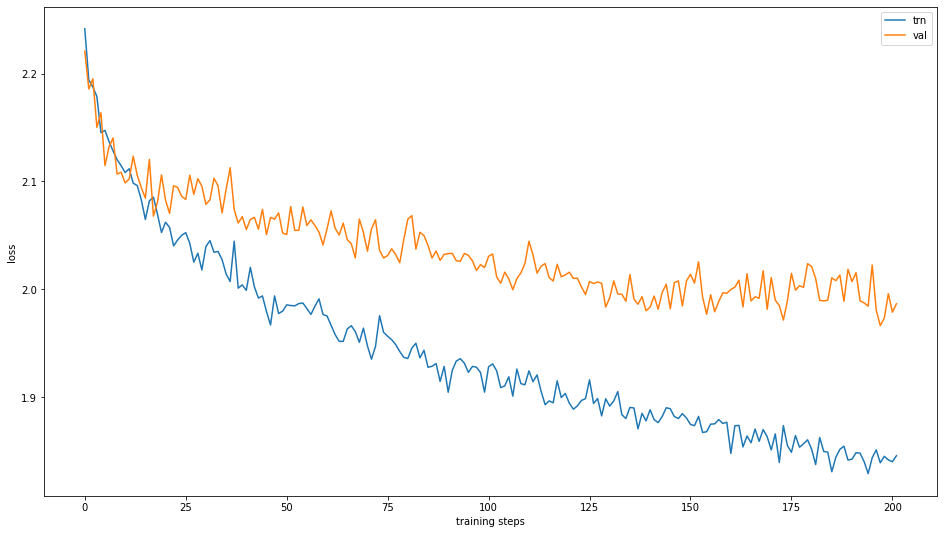

In [410]:
plt.figure(figsize=(16,9))
x_range = range(len(trn_loss_list))
plt.plot(x_range, trn_loss_list, label="trn")
plt.plot(x_range, val_loss_list, label="val")
plt.legend()
plt.xlabel("training steps")
plt.ylabel("loss")

In [411]:
# val acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(val_loader2):
        val_x, val_label = val
        if use_cuda:
            val_x = val_x.cuda()
            val_label =val_label.cuda()
        val_output = cnn(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("acc: {:.2f}".format(corr_num / total_num * 100))

acc: 46.70


In [412]:
# val acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(trn_loader2):
        val_x, val_label = val
        if use_cuda:
            val_x = val_x.cuda()
            val_label =val_label.cuda()
        val_output = cnn(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("acc: {:.2f}".format(corr_num / total_num * 100))

acc: 61.93


In [407]:
model_label

tensor([9, 2, 1, 1, 7, 8, 1, 6, 1])

In [338]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1,patience=5)

In [339]:
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.layer1 = self.conv_module(3, 16)
        self.layer3 = self.conv_module(16, 24)
        self.layer4 = self.conv_module(24, 32)
        self.layer5 = self.conv_module(32, 64)
        self.layer6 = self.conv_module(64,128)
        self.gap = self.global_avg_pool(128, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.gap(out)
        out = out.view(-1, 10)

        return out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1))

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))

In [340]:
model = CustomCNN()
model = model.to(device)
print(model)

CustomCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(32

In [341]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1,patience=5)

In [342]:
dataloaders = {"train":trn_loader,"val":val_loader}

In [345]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=8):

    global_info = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=11, verbose=True)
    for epoch in range(num_epochs):
        local_info = []
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':

                model.train()  # Set model to training mode
            else:

                model.eval()   # Set model to evaluate mode
                if epoch >0:
                    scheduler.step(val_loss)
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # outputs = outputs.argmax(dim=1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase])
            if phase == 'val':
                val_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.double() / len(dataloaders[phase])
            
            #(Variable(x).data).cpu().numpy()
            if phase == 'train':
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)
            else:
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        lr_get = get_lr(optimizer)
        print("Current learning rate : {:.8f}".format(lr_get))
        global_info.append(local_info)
        if phase =='val':
            early_stopping(epoch_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path=os.path.join(path_train,'checkpoint.pt'), trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss